In [1]:
%matplotlib inline

In [2]:
# from candlestick import candlestick
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import skimage.io

# Кратки бележки по проекта.



Целта на този проект е изготвянето на статия, която да представи пред широката публика резултатите от бектестове на някой от по-популярните технически индикатори и сигнали, които се ползват от начинаещите трейдъри, при търговията с финансови инструменти. Целевата аудитория, за която е предназначена статията е групата на хората без никакви основни познания за механизмите и начините на търговия с ценни книжа, а целта е да се предпазят тези хора от фалшив ентусиазъм и реална загуба на пари.

### 1. Структура на проекта

- Проекта е имплементиран на **Python**.
- Съдържанието на статия е поднесено във файл **Measuring_trading_strategies.pdf**
- Програмната част е отделена в папка **trading_strategies_code**, която има следната структура:

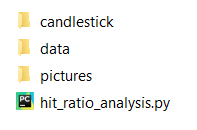

  1. Основната програмна логика се съдържа във файл __hit_ratio_analysis.py__

  2. Папка **candlestick** съдържа спомагателна библиотека за определяне на отделните модели от  кендъли. Библиотеката е взаимствана от https://pypi.org/project/candlestick-patterns-subodh101/ , но се наложи допълнително дописване за да придобие необходимата за проекта функционалност. *

  3.Папка **data** съдържа .csv файлове със сурови данни за цените на ценните книжа на ТОП 20 компании от S&P 500 Stocks по тяхното индексно тегло. Ползвани са исторически данни за различните компании за периоди от 3 до 10 години, взети на дневна база.  Във файл **samples.xlsx** е изнесена справка с броя исторически записи за всяка наблюдавана компания. 
  
  4. Папка **pictures** съдържа графики, необходими за онагледяване на концепциите залегнали в проекта. Всички графики и диаграми се генерират автоматично в тази папка директно от кода. Малка част от тях са пренесени в статията. 
  
Проекта съдържа още някой помощни файлове необходими за визуализирането на направените анализи.

_* Моля, не инсталирайте от посочения линк!_

### 2. Описание на заданието

В сферата на финансите, техническият анализ е методология за анализиране на финансовите пазари, чиято цел е да прогнозира вероятни изменения на цените на основата на закономерности – на основата на аналогични изменения в цените в миналото при сходни обстоятелства. Основните принципи на техническият анализ лежат на твърденията, че цената на пазара е отражение на цялата практически значима информация, в резултат на което анализът се фокусира върху търговската история на даден инструмент и не се влияе от външни фактори, като икономически, фундаментални и новинарски събития. В съвремието тази теория стои в противоречие със съвременната теория на портфейла. Ефективността на техническия и фундаментален анализ се оспорва от хипотезата за ефикасния пазар, която твърди, че цените на всеки търгуван инструмент по същество са непредвидими. 

В този проект е направен опит да се проверят доколко обективно работят някой основни хипотези на техническият анализ и къде е границата, до която трябва да им се доверим. Замислен е да бъде разработван в няколко части, като първата обхваща анализ на единични модели и стратегии за краткосрочна  търговия (с хоризонт до 5 дни), лежащи само върху тези модели. Целта е да се направи  софтуер, който прави бектестове на тези стратегии върху исторически данни с различен обхват. Втората част на проекта ще разгледа стратегии за търговия, комбиниращи няколко модела с един или повече технически индикатори. 

Този проект може да бъде разработен до етап, в който да може да тества индивидуални стратегии за търговия, дългосрочни стратегии за инвестиции и да бъде разширен до алгоритмичен робот за търговия.

На настоящият първи етап са избрани за тестване шест популярни модела базирани на японските свещи. Японските свещи представляват един от най-използваните видове графики за технически анализ на пазарите на ценни книжа. Счита се, че те превъзхождат значително линейните графики и са визуално по-приятни от бар графиките. Моделите от японски свещи на пазара представляват последователност от една, две или три свещи. Счита се че формирането на определен сигнал е белег на определена промяна в пазарната цена. Подробно описание на конкретните модели е поднесено в статията към този проект.

Изчисленията са направени на база ТОП 20 компании от S&P 500 Stocks, класирани по тяхното индексно тегло. Компаниите са ликвидни и пазарите, на които се търгуват отговарят на определенията за ефективен пазар според съвремените финансови изисквания. Анализа е базиран на 10-годишна хронология. Аргументите за този избор са, че профила на пазарите на ценни книжа се промени съществено, след навлизането на дигиталните технологии и високочестотната търговия с алгоритми, преди около 10-15 години. Източника на данните за цените е https://finance.yahoo.com/. Данните се предоставят безплатно, общодостъпни са и са с висока степен на представителност. 

Представеният по-долу алгоритъм обхожда данните за всяка компания и маркира дните, в които засича определен модел (сигнал за търговия). След това се изчислява един от основните показатели **Hit Ratio**, дали този сигнал е бил достоверен в дефиниран предварително кратък период от време (в случая 5 дни) по формулата:
$$ HitRatio = \frac{CountSuccess}{CountSignals}$$ 
Неговото честотното разпределение за дадената стратегия е измерител на вероятността й за "успех". Стойности под 0,5 показват, че избраната стратегия (модел) би могла  да доведе до загуба над 50% от случаите, в която я използваме.

Алгоритъма е подготвен за доразработка в още две направления:


1. Добавени са техническите осцилатори RSI (Relative Strength Index), Индикаторът експоненциална пълзяща средна (EWM), които позволяват да се изготвят по прецизни комбинирани стратегии за търговия. След което да се тества HitRatio за тях.
    Пълзяща средна стойност е статистическа функция, която включва изчислението на поредица от средни стойности на различни подмножества от стойности от дадено множество. Използва се най-често при времеви редове за анализ на тенденцията на изменение.
     Експоненциалната пълзяща средна (EMA) е средно претеглена стойност на последната n цени, където тежестта намалява експоненциално с всяка предходна цена / период. С други думи, формулата дава на последните цени по-голяма тежест от предишните:
    
    $$EWM_{n} = (P_{Close} - EWM_{n-1}) * (\frac {2}{n + 1}) + EWM_{n-1}$$
    
    където $EWM_{n}$ е новата средна стойност, $P_{Close}$ е цената на затваряне в деня $n$ и $EWM_{n-1}$ е предходната средна стойност.
    

Алгоритъмът, по който се изчислява $RSI$ се състои в следното:

Ако предходната цена на затваряне е по-ниска от текущата полагаме:
$$U = close_{now} – close_{previous}$$
$$D = 0$$
    В противен случай:
$$U = 0$$
$$D = close_{previous} – close_{now}$$
    Изчисляваме Относителната сила (RS) по:
$$RS = \frac{EWM(U)}{EWM(D)}$$
    След което се нормализира в интервала 0 до 100:
$$RSI = 100 – \frac{100} {(1 + RSI)} $$ 


    
2. В статията са засегнати като терминология още няколко измерителя, като Профит-фактор (Profit Factor или съотношението от сумата на всички печеливши сделки към сумата на всички неуспешни) и Риск/Печалба (Risk/Reward - потенциалната награда, която инвеститорът може да спечели за всеки лев, който рискува от инвестиция), които могат да донастроят изискванията на трейдъра по отношение на стратегията. Идеята да се въведе тази терминология в заключението на статията е да се направи плавен преход към разширяването на темата на следващия етап, където ще се тестват комбинирани стратегии.

$$Profit Factor = \frac{\sum PROFITS_{Winning Trades}}{\sum LOSSES_{Losing Trades}}$$

или още

$$Profit Factor =  \frac {GrossProfit} {GrossLoss}$$


Съотношението Risk/Reward може да се онагледи със следната графика:

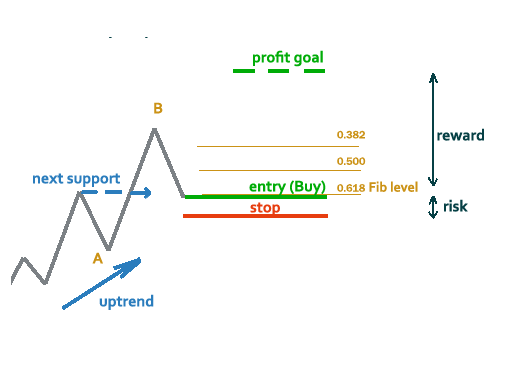


и се представя със:

$$R/R Ratio =  \displaystyle\left\lvert \frac{P_{entry}-SL_{Value}}{P_{entry}-TP_{Value}}\right\rvert $$

където:

$R/R Ratio$ е съотношението Риск/Печалба

$P_{entry}$ е цената на влизане в пазара

$SL_{Value}$ е нивото на ограничаване на загубите или нивото на което поставяме stop lost (на графиката "stop")

$TP_{Value}$ е целевото ниво на излизане от позицията, което наричаме target price value (на графиката "profit goal")

### 3. Описание на кода

По-долу е описана програмната логика. 

а/ В кода са дефинирани предварително някой константи и обекти, които се ползват на различните етапи от изчисленията.

In [ ]:
CHART_MIN = -200
CHART_MAX = -1
MARKERSIZE = 50
DOWN_INDICATOR = 0.98
UP_INDICATOR = 1.02
STOP_LEVEL = 0.02
STOP_LEVEL_LOST = 0.01
HOLDING_PERIOD = 5

# Top 20 S&P 500 Stocks by Index Weight
shares = {
    'Facebook Inc. (FB)': 'FB.csv',
    'Moderna Inc. (MRNA)': 'MRNA.csv',
    'Amazon.com Inc. (AMZN)': 'AMZN.csv',
    'Alphabet Inc. (GOOG)': 'GOOG.csv',
    'Microsoft Corporation (MSFT)': 'MSFT.csv',
    'Apple Inc. (AAPL)': 'AAPL.csv',
    'Tesla Inc. (TSLA)': 'TSLA.csv',
    'Berkshire Hathaway Inc. (BRK-B)': 'BRK.csv',
    'JPMorgan Chase & Co. (JPM)': 'JPM.csv',
    'Johnson & Johnson (JNJ)': 'JNJ.csv',
    "Visa Inc. (V)": "V.csv",
    "UnitedHealth Group Incorporated (UNH)": "UNH.csv",
    "NVIDIA Corporation (NVDA)": "NVDA.csv",
    "The Home Depot Inc. (HD)": "HD.csv",
    "The Procter and Gamble Company (PG)": "PG.csv",
    "Mastercard Incorporated (MA)": "MA.csv",
    "Bank of America Corporation (BAC)": "BAC.csv",
    "PayPal Holdings Inc. (PYPL)": "PYPL.csv",
    "Intel Corporation (INTC)": "INTC.csv",
    "Comcast Corporation (CMCSA)": "CMCSA.csv",
}

signals_parameters = {'BullishEngulfing': 'bull',
                      'BearishEngulfing': 'bear',
                      'EveningStar': 'bear',
                      'InvertedHammers': 'bull',
                      'Hammer': 'bull',
                      'MorningStar': 'bull'}

df_coefficients = {'BullishEngulfing': [],
                   'BearishEngulfing': [],
                   'EveningStar': [],
                   'InvertedHammers': [],
                   'Hammer': [],
                   'MorningStar': []}

signal_names = [k for k in signals_parameters.keys()]

mapper = {'BullishEngulfing': candlestick.bullish_engulfing,
          'BearishEngulfing': candlestick.bearish_engulfing,
          'EveningStar': candlestick.evening_star,
          'InvertedHammers': candlestick.inverted_hammer,
          'Hammer': candlestick.hammer,
          'MorningStar': candlestick.morning_star}

б/ Основната бизнес логика е заложена по-долу.

In [ ]:
for company_name, data_file in shares.items():
    df = read_data_from_file(data_file)
    with open("data/samples.csv", "a") as fl:
        fl.write(f'{company_name}, {len(df)}\n')
    make_chart(df)
    for signal_name in signal_names:
        signal_coefficients = get_signal_coefficients(signal_name, df)
        df_coefficients[signal_name].append(signal_coefficients[0])
# for k,v in df_coefficients.items():
#     value_mean = np.array(v).mean()
#     print( round(value_mean,2))
plot_df_coefficients_histograms(df_coefficients)
plot_hit_ratio(df_coefficients)


в/ Програмата стартира с четене на .csv файла за конкретната компания, след което данните се добавят в **pandas.DataFrame обект**. На този етап се изчисляват и добавят индикаторите EWM и RSI. Добавят се колони с генерираните сигнали - булеви стойности, съобщаващи наличието или липсата на сигнал за всяка разглеждана дата.
Функцията за четене на данните връща готовия за обработки обект.

In [ ]:

def read_data_from_file(data_file):
    with open(f"data/{data_file}") as f:
        df = pd.read_csv(f, index_col=0, parse_dates=["date"])
    f.close()

    candles_df = pd.DataFrame(df,
                              columns=['T', 'open', 'high', 'low', 'close', 'volume', 'CT', 'QV', 'N', 'TB', 'TQ', 'I'])
    candles_df.index.name = 'date'

    # Add Exponential moving average EWM
    ewm_short = pd.DataFrame(df['adj close'].ewm(span=21, adjust=False).mean())
    candles_df['EWM'] = ewm_short

    # calculate Relative Strength Index (RSI)
    delta = df['adj close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down

    candles_df['RSI'] = 100 - (100 / (1 + rs))

    # add signals column
    for t, f in mapper.items():
        target = t
        candles_df = f(candles_df, target=target)

    return candles_df
 

Изчисленията са направени на база ТОП 20 компании от S&P 500 Stocks, класирани по тяхното индексно тегло. Анализа е базиран на 10-годишна хронология. Две от компаниите нямат пълна 10-годишна история. Всички получени данни надолу са направени на база тази извадка с посочените й характеристики.

In [3]:
companies_observation=pd.read_csv('samples.csv', header = None, sep = ',')
companies_observation.columns = ["Name", "Count observation"]
companies_observation

,Name,Count observation
0,Facebook Inc. (FB),2252
1,Moderna Inc. (MRNA),603
2,Amazon.com Inc. (AMZN),2265
3,Alphabet Inc. (GOOG),2265
4,Microsoft Corporation (MSFT),2265
5,Apple Inc. (AAPL),2265
6,Tesla Inc. (TSLA),2265
7,Berkshire Hathaway Inc. (BRK-B),2265
8,JPMorgan Chase & Co. (JPM),2265
9,Johnson & Johnson (JNJ),2265


г/ Следващата стъпка е визуалното графичното представяне на обработените данни с функцията **make_chart(candles_df)**. Първоначално данните се изследват за наличие на съответният сигнал и информацията се натрупва в обект от типа list, който в последствие формира съответният маркер за сигнал на основната графика. С  **mpf.make_addplot** се добавя всички subplots към основната графика - за шестте вида сигнали,  EWM и RSI. С **mpf.plot** се изчертава комплексната графика. Изображението се записва във файл, чието име се генерира динамично като приема борсовия код на компанията, с която се работи текущо.

In [ ]:
def signal_chart(serries, price, up_down_indicator):
    signal = []
    for i in range(0, len(serries)):
        if serries[i] == True:
            signal.append(price[i] * up_down_indicator)
        else:
            signal.append(np.nan)
    return signal


def make_chart(candles_df):
    try:
        td_bull_esc = signal_chart(candles_df['BullishEngulfing'], candles_df['close'], DOWN_INDICATOR)
        td_bear_esc = signal_chart(candles_df['BearishEngulfing'], candles_df['close'], UP_INDICATOR)
        td_inv_ham = signal_chart(candles_df['InvertedHammers'], candles_df['close'], DOWN_INDICATOR)
        td_ham = signal_chart(candles_df['Hammer'], candles_df['close'], DOWN_INDICATOR)
        td_mor_star = signal_chart(candles_df['MorningStar'], candles_df['high'], DOWN_INDICATOR)
        td_eve_star = signal_chart(candles_df['EveningStar'], candles_df['low'], UP_INDICATOR)

        # TODO - Correct CHART_MIN:CHART_MAX and make cycle/comprehension for get different plots
        adps = [mpf.make_addplot(candles_df['EWM'][CHART_MIN:CHART_MAX], color='r', linestyle='dotted'),
                mpf.make_addplot(candles_df['RSI'][CHART_MIN:CHART_MAX], panel=1, color='black', linestyle='dotted',
                                 secondary_y=True),
                mpf.make_addplot(td_bull_esc[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='green'),
                mpf.make_addplot(td_bear_esc[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='v',
                                 color='red'),
                mpf.make_addplot(td_inv_ham[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='grey'),
                mpf.make_addplot(td_ham[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='orange'),
                mpf.make_addplot(td_mor_star[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='cyan'),
                mpf.make_addplot(td_eve_star[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='v',
                                 color='magenta'),
                ]
        mpf.plot(candles_df[CHART_MIN:CHART_MAX], type='candle', style='yahoo', volume=True, volume_panel=1,
                 figratio=(15, 7), addplot=adps,
                 title=f"\n\n{company_name} prices,\n six popular signals",
                 savefig=f"pictures/{company_name}.png")  # , savefig=f"pictures/{company_name}.png"
    except:
        return

Графиката има следният вид:

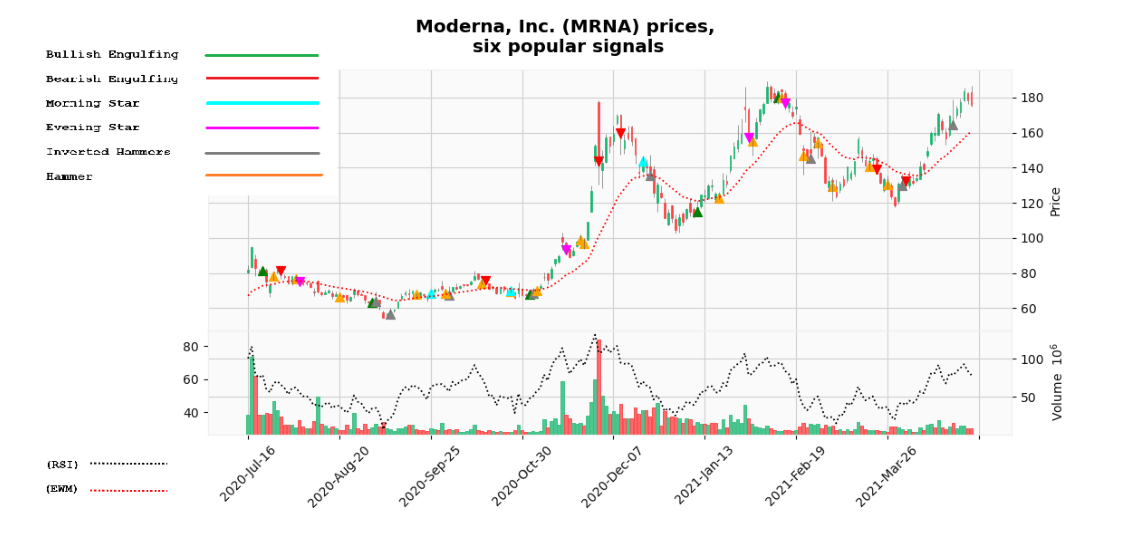

In [4]:
def read_image(path):
    img = skimage.io.imread(path)
    return img

company_image_MRNA = read_image('Moderna, Inc. (MRNA)-stat.png')
plt.figure(figsize = (20,12))
plt.imshow(company_image_MRNA)
plt.axis("off")
plt.show()

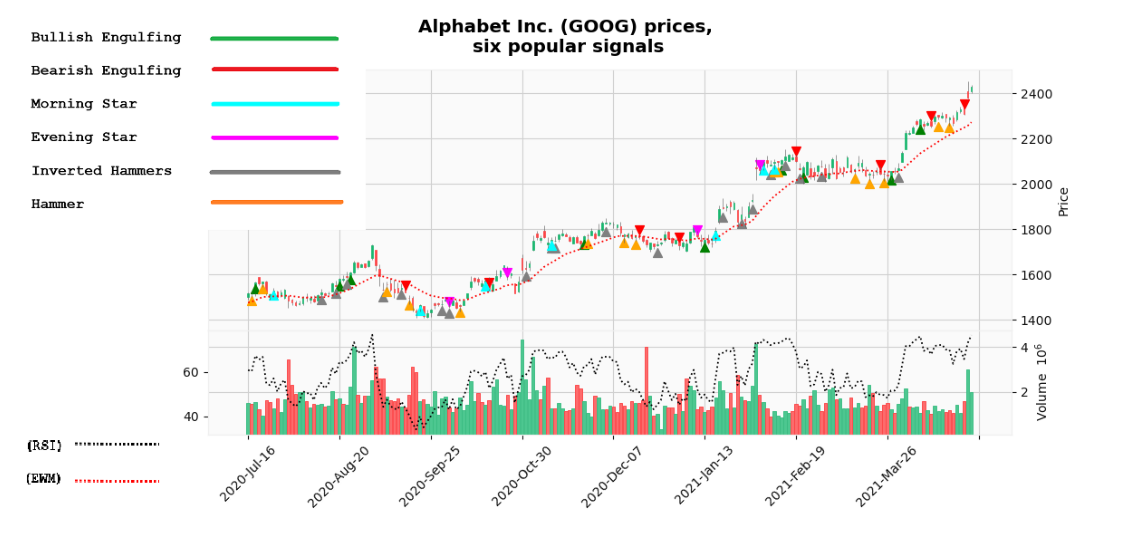

In [5]:
company_image_GOOG = read_image('Alphabet Inc. (GOOG)-stat.png')
plt.figure(figsize = (20,12))
plt.imshow(company_image_GOOG)
plt.axis("off")
plt.show()

д/ Логиката продължава с генериране на показателя, чийто поведение изследваме: 
$$ HitRatio = \frac{CountSuccess}{CountSignals}$$ 

In [ ]:
def get_count_of_success(signal_name, df):
    count_of_success = 0
    price_level = ''
    price_stop_coefficient = 1
    if signals_parameters[signal_name] == 'bull':
        price_level = "high"
        price_stop_coefficient = 1
    else:
        price_level = "low"
        price_stop_coefficient = -1
    for ind in df.index:
        if df[signal_name][ind] == True:  # and (df['RSI']>70 or df['RSI']<30)
            price = df[price_level][ind]
            price_stop = price + price * price_stop_coefficient * STOP_LEVEL
            idx = ind
            for i in range(1, HOLDING_PERIOD):
                date = pd.to_datetime(idx)
                try:
                    idx = next(j for j in df.index if j > date)
                    if price_stop_coefficient == 1:
                        if df[price_level][idx] >= price_stop:
                            count_of_success += 1
                            break
                    elif price_stop_coefficient == -1:
                        if df[price_level][idx] <= price_stop:
                            count_of_success += 1
                            break
                except:
                    continue
    return count_of_success


def get_signal_coefficients(signal_name, df):
    count_of_signals = len(df.loc[df[signal_name] == True])
    count_of_success = get_count_of_success(signal_name, df)
    hit_ratio = round(count_of_success / count_of_signals, 2)
    return (hit_ratio, count_of_signals, count_of_success)

е/ На последният етап от кода се правят описаните анализи и разрези на обработените данни. Тук се чертаят хистограмите на отделните сигнали, както и категорийна диаграма със средните HitRatio на отделните сигнали.

In [ ]:
def plot_hit_ratio(df_coefficients):
    mean_hit_ratios = {}
    combined_label = ''

    for name, data in df_coefficients.items():
        mean_hit_ratio = round(np.array(data).mean(), 2)
        mean_hit_ratios[name] = mean_hit_ratio

    for k, v in mean_hit_ratios.items():
        combined_label += f"{k} : {v}\n"

    x = [k for k in mean_hit_ratios.keys()]
    y = [v for k, v in mean_hit_ratios.items()]
    plt.figure(figsize=(15, 8))
    plt.barh(x, y, color="green", label=combined_label)
    plt.title('Hit Ratio means', fontsize=24)
    legend = plt.legend()
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('Signals', fontsize=16)
    plt.xlabel('Hit Ratio', fontsize=16)
    plt.savefig("pictures/hit_ratio_barh.png")
    plt.show()


def plot_df_coefficients_histograms(df_coefficients):
    coef = pd.DataFrame.from_dict(df_coefficients)
    print(coef)
    coef.to_csv ( r'data/coef.csv', index=False, header=True )

    for name, data in df_coefficients.items():
        c_mean = round(coef[name].mean(), 4)
        c_std = round(coef[name].std(ddof=0), 4)
        c_skew = round(coef[name].skew(), 4)
        c_kurtosis = round(coef[name].kurtosis(), 4)
        statistical_indicators = f"Mean: {c_mean}\nStandard deviation: {c_std}\nSkewness: {c_skew}\nKurtosis: {c_kurtosis}"

        fig = plt.figure ()
        ax = fig.add_subplot ()
        plt.title(f'Hit ratios {name} signal')
        plt.ylabel('Count of companies')
        plt.yticks(range(8), range(8))
        plt.axvline(x=c_mean, color = 'red', alpha = 0.7, linewidth = 3,linestyle ="--") #label = '$\mu$'  label = '$\mu-\sigma$'  label = '$\mu+\sigma$'
        plt.axvline ( x=c_mean-c_std, color='red', alpha = 0.7, linewidth=2, linestyle="--" )
        plt.axvline ( x=c_mean + c_std, color='red', alpha = 0.7, linewidth=2, linestyle="--")
        ax.text ( c_mean+0.01, 3, '$\mu$', rotation = 'vertical', verticalalignment ='center')
        ax.text ( c_mean-c_std+0.01,3, '$\mu-\sigma$',rotation = 'vertical', verticalalignment ='center' )
        ax.text ( c_mean + c_std+0.01,3, '$\mu+\sigma$' , rotation = 'vertical', verticalalignment ='center')

        plt.xlabel('Hit Ratio')
        plt.hist(coef[name], bins=10, label=statistical_indicators)
        legend = plt.legend()
        plt.savefig(f"pictures/hit_ratios_{name}_histogram.png")
        plt.show()

Кода обработва генерираните сигнали и генерира динамично съответните графики и хистограми.

По-долу е посочена примерна хистограма за сигнала BearishEngulfing. Работи се с пълния набор от данни.

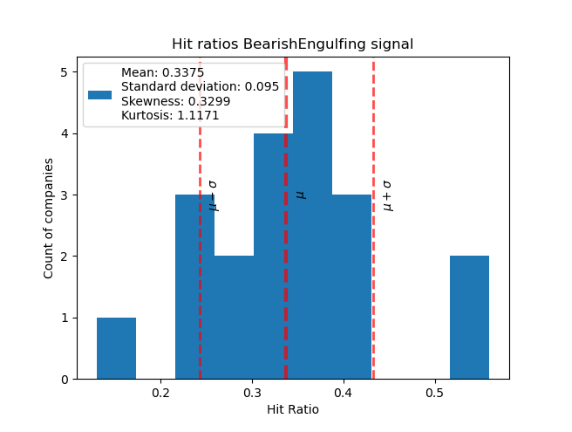

In [6]:
histogram_image = read_image('hit_ratios_BearishEngulfing_histogram.png')
plt.figure(figsize = (10,10))
plt.imshow(histogram_image)
plt.axis("off")
plt.show()

И примерна категорийна диаграма HitRatio mean на сигналите. Данните са предоставени в таблицата по-долу. Конкретният пример е при следните входни параметри: Хоризонта на задържане 5 дни и целевото ниво на излизане от позицията +/-0,2%

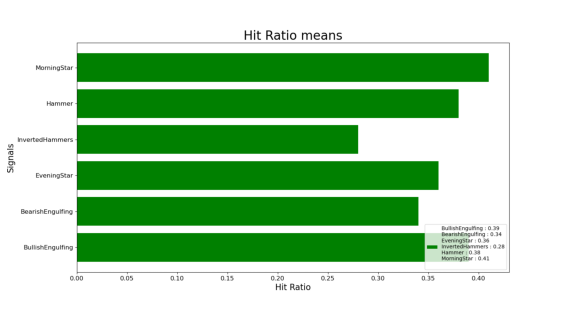

In [7]:
barh_image = read_image('hit_ratio_barh_holding5days.png')
plt.figure(figsize = (10,10))
plt.imshow(barh_image)
plt.axis("off")
plt.show()

In [8]:
hit_ratios = pd.read_csv('coef.csv')
hit_ratios

,BullishEngulfing,BearishEngulfing,EveningStar,InvertedHammers,Hammer,MorningStar
0,0.36,0.40,0.33,0.32,0.41,0.49
1,0.67,0.56,0.70,0.38,0.58,0.62
2,0.44,0.39,0.31,0.29,0.41,0.54
3,0.38,0.37,0.49,0.30,0.35,0.38
4,0.34,0.36,0.38,0.26,0.35,0.31
5,0.32,0.37,0.42,0.29,0.38,0.46
6,0.61,0.52,0.78,0.48,0.61,0.59
7,0.25,0.13,0.27,0.16,0.19,0.30
8,0.31,0.31,0.25,0.26,0.34,0.37
9,0.11,0.23,0.35,0.16,0.25,0.26


In [9]:
hit_ratios.mean()

BullishEngulfing    0.3910
BearishEngulfing    0.3375
EveningStar         0.3550
InvertedHammers     0.2775
Hammer              0.3840
MorningStar         0.4125
dtype: float64

In [10]:
hit_ratios.std(ddof=0)

BullishEngulfing    0.134681
BearishEngulfing    0.094967
EveningStar         0.160390
InvertedHammers     0.087799
Hammer              0.103363
MorningStar         0.113132
dtype: float64

Пълният каталог с генерираните изображения се намира в папка pictures към проекта.

### 4. Анализ на резултатите

По нататък е направен анализ на чувствителността на показателя спрямо промяната във входните параметри. Разглеждат се две направления.

При равни други условия, как реагира показателя за различните сигнали при:
- промяна на хоризонта на задържане на книжата;
- промяна на целевото ниво на излизане от позицията.

Резултатите са систематизирани в подпапки на папка в графичен вид в папка pictures\pictures_catalog_10years_history. 

Така направени, резултатите показват, че при увеличаване на периода на задържане на книжата HitRatio показват склонност към увеличение на коефициента. Тук трябва да се отбележи, че този резултат не може да се счита представителен в този му вид, тъй като не е отчетено евентуално поставяне на stop lost, което може да предизвика преждевременно излизане от позицията при евентуална ценова флуктуация и съответно генериране на загуби. Длъжни сме да отбележим, че при такива флуктуации, самия профил на HitRatio би се променил. Предмет на този анализ ще бъде следващата статия, която ще проследи в пълнота тези ценови флуктуации. В долната таблица са представени обобщени резултати за поведението на показателя при различни хоризонти на задържане.

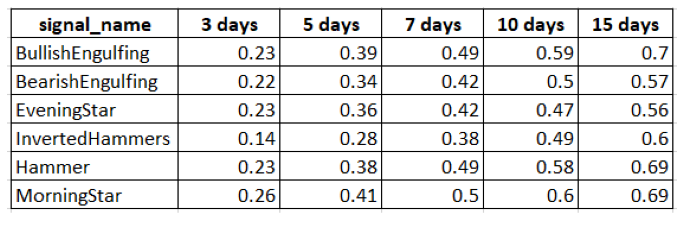

In [11]:
table_hr = read_image('Table_Hit_Ratios.png')
plt.figure(figsize = (12,6))
plt.imshow(table_hr)
plt.axis("off")
plt.show()

Промяна на целевото ниво на излизане от позицията също влияе върху HitRatio, като логично може да се очаква, че при по-ниски изисквания към печалба или с други думи, при по ниска толерантност към риск, вероятността за успех на стратегията се променя в положителна посока. Изискванията за печалба не могат да спаднат обаче под нивото на транзакционите (и някой др. разходи, като комисионни към брокера, борсата към клиринговата институция и т.н.) разходи по сделката и в този смисъл, влизайки в позиция, инвеститора така или иначе поема определено ниво на константен риск. По долу са онагледени обобщените резултати за HitRatio при три различни целеви нива на излизане.

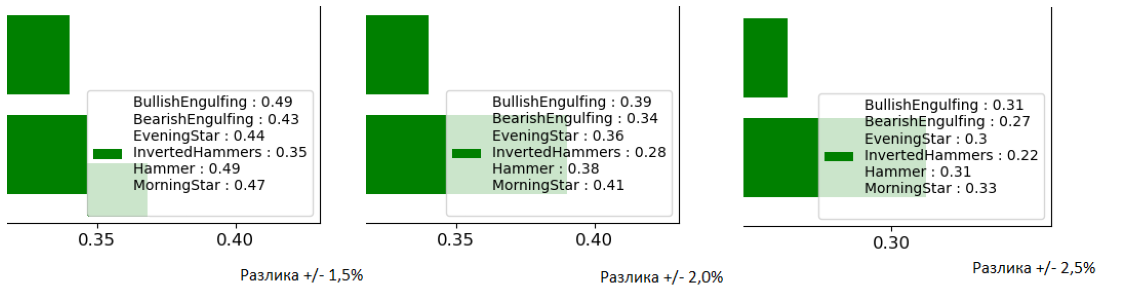

In [12]:
barh_image_sl = read_image('Barh_sl.png')
plt.figure(figsize = (20,10))
plt.imshow(barh_image_sl)
plt.axis("off")
plt.show()

### 5. Заключителни бележки

- Тестването на кода на всеки от етапите е осъществявано през PyCharm, чрез функционалността му за debug.
- Идеята за този проект е  да бъде развит поетапно в следващите курсове до алгоритъм, предназначен за автоматична търговия. 
- Самооценката по проекта е предоставена във файл SelfAssessment.txt в основната директория на проекта.

### References:


www.investopedia.com/

https://finance.yahoo.com/

https://admiralmarkets.com/

https://karollbroker.bg

https://pypi.org/project/candlestick-patterns-subodh101/

https://github.com/matplotlib/mplfinance

https://kaabar-sofien.medium.com/
